In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive/noveno/Parte1 - Sesion1 - Imagenes Espectrales/Imagenes-espectrales-session")


Mounted at /content/drive


In [3]:
!pip install earthpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 53.8 MB/s eta 0:00:00


In [6]:
from scipy.io import loadmat
import earthpy.spatial as es
import earthpy.plot as epp
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import torch
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch import nn
from torch import optim
import seaborn as sns
import time
import joblib
import copy
sns.set()

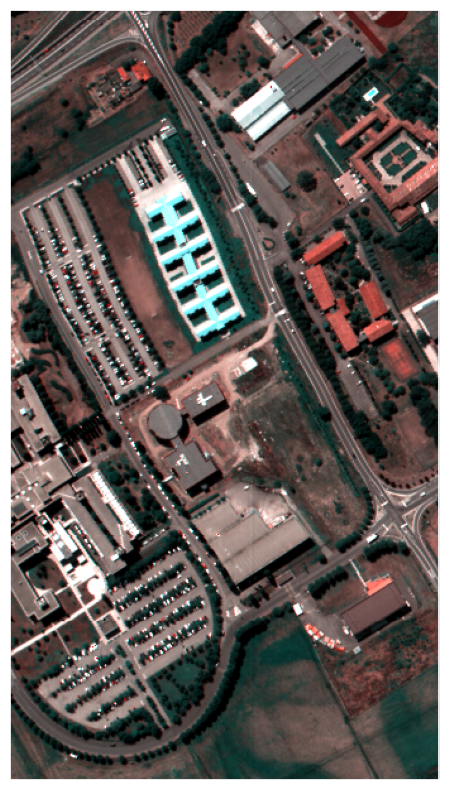

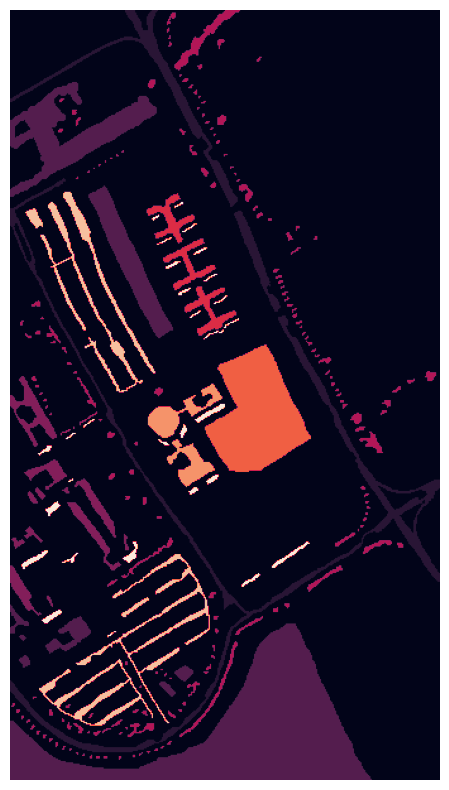

In [7]:
data_path = '/content/drive/MyDrive/noveno/Parte1 - Sesion1 - Imagenes Espectrales/Imagenes-espectrales-session/PaviaU.mat'  # Update this path
ground_truth_path = '/content/drive/MyDrive/noveno/Parte1 - Sesion1 - Imagenes Espectrales/Imagenes-espectrales-session/PaviaU_gt.mat'  # Update this path

data = loadmat(data_path)['paviaU']
gt = loadmat(ground_truth_path)['paviaU_gt']

df = pd.DataFrame(data.reshape(data.shape[0]*data.shape[1], -1))
df.columns = [f'band{i}' for i in range(1, df.shape[-1]+1)]
df['class'] = gt.ravel()
df = df[df['class']!=0]

stacked_bands = np.transpose(data, (2, 0, 1))
sampled_bands = np.array([stacked_bands[0], stacked_bands[50], stacked_bands[100]])
bands = [f'Band {i}' for i in range(1, 102, 50)]
colors = list(mcolors.BASE_COLORS)

epp.plot_rgb(
    stacked_bands,
    rgb=(60, 30, 27),
    stretch=True,
    figsize=(10, 10),
)

plt.figure(figsize=(10, 10))
plt.imshow(gt)
plt.axis('off')
plt.show()




In [8]:
def zeros_pad(x, margin):
    padded_x = torch.zeros((x.shape[0] + 2 * margin, x.shape[1] + 2 * margin, x.shape[2]))
    padded_x[margin:x.shape[0] + margin, margin:x.shape[1] + margin, :] = x
    return padded_x

def create_image(x, y, window_size):
    margin = (window_size - 1) // 2
    padded_x = zeros_pad(x, margin=margin)
    patched_x = torch.zeros((x.shape[0] * x.shape[1], window_size, window_size, x.shape[2]))
    patched_y = torch.zeros((x.shape[0] * x.shape[1]))
    patch_index = 0
    for i in range(margin, padded_x.shape[0] - margin):
        for j in range(margin, padded_x.shape[1] - margin):
            patch = padded_x[i - margin:i + margin + 1, j - margin:j + margin + 1]
            patched_x[patch_index, :, :, :] = patch
            patched_y[patch_index] = y[i-margin, j-margin]
            patch_index += 1
    patched_x = patched_x[patched_y>0,:,:,:]
    patched_y = patched_y[patched_y>0]
    patched_y -= 1
    return patched_x, patched_y

In [9]:
dimensions = 17
window_size = 25
pca = PCA(n_components=dimensions)
test_perc = 0.3

x = np.reshape(data, (-1, data.shape[2]))
x_pca = pca.fit_transform(x)
x_pca = np.reshape(x_pca, (data.shape[0], data.shape[1], dimensions))
cnn_x, cnn_y = create_image(torch.tensor(x_pca.astype(np.float32)), gt, window_size=window_size)
# number of items in batch, number of channels, number of images in sequence, height of image, width of image
cnn_x = torch.permute(cnn_x[:, None, :, :, :], (0, 1, 4, 2, 3))
cnn_x_train, cnn_x_test, cnn_y_train, cnn_y_test = train_test_split(cnn_x, cnn_y, test_size=test_perc, stratify=cnn_y, random_state = 42)

train = data_utils.TensorDataset(cnn_x_train, cnn_y_train)
trainloader = data_utils.DataLoader(train, batch_size=10, shuffle=True)
test = data_utils.TensorDataset(cnn_x_test, cnn_y_test)
testloader = data_utils.DataLoader(test, batch_size=10, shuffle=True)

In [10]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.cv1 = nn.Conv3d(1, 8, kernel_size=(3,3, 5))
        self.cv2 = nn.Conv2d(8, 16, kernel_size=(3,3))
        self.fc1 = nn.Linear(100048, 128)
        self.dp = nn.Dropout(p=0.4)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.cv1(x)
        out = F.relu(out)
        out = torch.reshape(out, (out.shape[0], out.shape[1], out.shape[2], out.shape[3]*out.shape[4]))
        out = self.cv2(out)
        out = F.relu(out)
        out = torch.flatten(out, 1)
        out = self.fc1(out)
        out = self.dp(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

In [11]:
def train_val_plot(loss_plot, val_loss_plot, acc_plot, val_acc_plot):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    ax[0].plot(loss_plot, label="Training Loss")
    ax[0].plot(val_loss_plot, label="Test Loss")
    ax[0].legend(fontsize=18)
    ax[0].grid(True)
    ax[0].set_title("Training/Test Loss", fontsize=20);
    ax[0].set_xlabel("Epoch", fontsize=18);
    ax[0].set_ylabel("Loss", fontsize=18);
    ax[1].plot(acc_plot, label="Training accuracy")
    ax[1].plot(val_acc_plot, label="Test accuracy")
    ax[1].legend(fontsize=18)
    ax[1].grid(True)
    ax[1].set_title("Training/Test Accuracy", fontsize=20);
    ax[1].set_xlabel("Epoch", fontsize=18);
    ax[1].set_ylabel("Accuracy (%)", fontsize=18);
    plt.show()

In [12]:
def train_model(model, criterion, optimizer, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    loss_plot, acc_plot = [], []
    val_loss_plot, val_acc_plot = [], []
    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels.long())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data.long())

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                loss_plot.append(epoch_loss)
                acc_plot.append(epoch_acc)
            else:
                val_loss_plot.append(epoch_loss)
                val_acc_plot.append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Best val Loss: {:4f}'.format(best_loss))

    # loading best model weights
    model.load_state_dict(best_model_wts)
    train_val_plot(loss_plot, val_loss_plot, acc_plot, val_acc_plot)
    return model

Training complete in 65m 59s
Best val Acc: 0.918258
Best val Loss: 0.386135


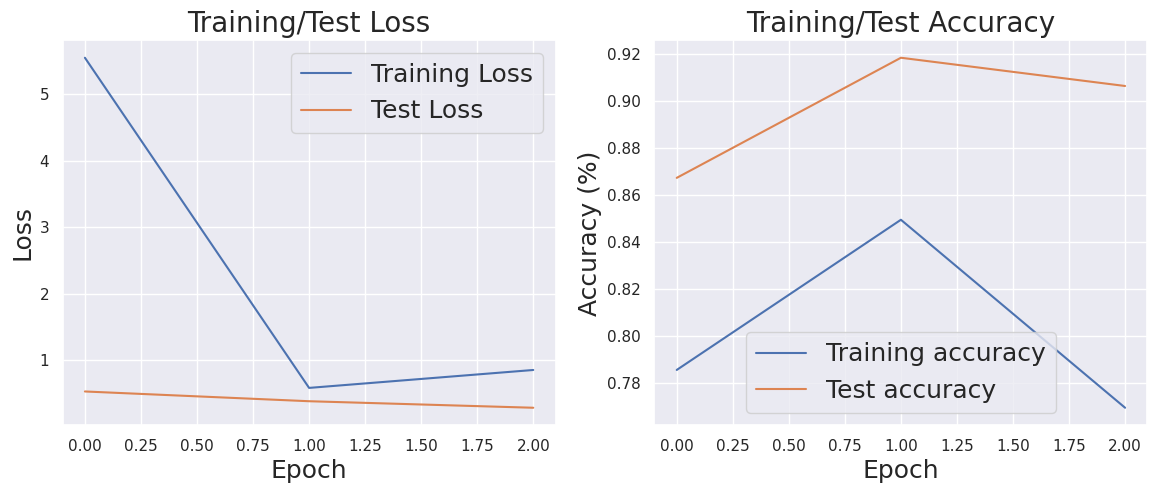

CNNModel(
  (cv1): Conv3d(1, 8, kernel_size=(3, 3, 5), stride=(1, 1, 1))
  (cv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=100048, out_features=128, bias=True)
  (dp): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=128, out_features=9, bias=True)
)

In [13]:
dataloaders = {'train': trainloader, 'val': testloader}
dataset_sizes = {'train': len(trainloader.dataset), 'val': len(testloader.dataset)}
model = CNNModel(9)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model.parameters())
train_model(model, criterion, optimizer_ft, num_epochs=3)

In [14]:
torch.save(model, '/content/drive/MyDrive/noveno/Parte1 - Sesion1 - Imagenes Espectrales/Imagenes-espectrales-session/complete_model.pth')


In [15]:
# Guardar los conjuntos de datos particionados
torch.save(cnn_x_train, '/content/drive/MyDrive/noveno/Parte1 - Sesion1 - Imagenes Espectrales/Imagenes-espectrales-session/cnn_x_train.pth')
torch.save(cnn_x_test, '/content/drive/MyDrive/noveno/Parte1 - Sesion1 - Imagenes Espectrales/Imagenes-espectrales-session/cnn_x_test.pth')
torch.save(cnn_y_train, '/content/drive/MyDrive/noveno/Parte1 - Sesion1 - Imagenes Espectrales/Imagenes-espectrales-session/cnn_y_train.pth')
torch.save(cnn_y_test, '/content/drive/MyDrive/noveno/Parte1 - Sesion1 - Imagenes Espectrales/Imagenes-espectrales-session/cnn_y_test.pth')

# Guardar el modelo PCA
joblib.dump(pca, '/content/drive/MyDrive/noveno/Parte1 - Sesion1 - Imagenes Espectrales/Imagenes-espectrales-session/model_pca.pkl')

['/content/drive/MyDrive/noveno/Parte1 - Sesion1 - Imagenes Espectrales/Imagenes-espectrales-session/model_pca.pkl']